# 0. Imports

In [45]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.rcParams['font.size'] = 5

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
    jupyter_settings()

In [7]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


## data load

In [11]:
!l


'l' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [14]:
#dados obtidos via kaggle 
df1 = pd.read_csv('datasets/Rossmann/train.csv', low_memory=False)
df2 = pd.read_csv('datasets/Rossmann/store.csv')

In [15]:
df = pd.merge(df1,df2,how='left',on='Store')

In [16]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [17]:
df2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. DATA PROCESSING

## 1.1 Data clean

In [19]:
shape=df.shape
print('--o dataset contem--\nlinhas = {} \ncolunas = {}'.format(shape[0],shape[1]))

--o dataset contem--
linhas = 1017209 
colunas = 18


In [20]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [21]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#renomear colunas
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [22]:
#Date = object
df['date'] = pd.to_datetime(df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##1.2 Check NA

In [23]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [24]:
#competition_distance - distance in meters to the nearest competitor store
df['competition_distance']= df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)
                                                             else x )
#competition_open_since_month
df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                              else x['competition_open_since_month'],axis=1)

 
#competition_open_since_year
df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                              else x['competition_open_since_year'],axis=1)
#promo2_since_week 
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                              else x['promo2_since_week'],axis=1)

#promo2_since_year
df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                              else x['promo2_since_year'],axis=1)
#promo_interval
df['promo_interval'].fillna(0,inplace=True)

month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df['month_map'] = df['date'].dt.month.map(month_map)

df['is_promo']= df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)




df.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [25]:

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')
df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
df['promo2_since_year'] = df['promo2_since_year'].astype('int64')
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

##1.3 Descriptive Statistical

In [27]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

###1.3.1 Numerical Attributes

In [28]:
#medidas tendencia central - mean,median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão - std,skew,kurtosis,min,max,range

ct3 = pd.DataFrame(num_attributes.apply( np.std ) ).T
ct4 = pd.DataFrame(num_attributes.apply( min ) ).T
ct5 = pd.DataFrame(num_attributes.apply( max ) ).T
ct6 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
ct7 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
ct8 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#concatenate

metrics = pd.concat([ct4,ct5,ct8,ct1,ct2,ct3,ct7,ct6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','kurtosis','skew']
metrics

,attributes,min,max,range,mean,median,std,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


###1.3.1 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

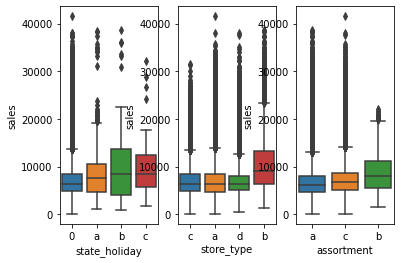

In [30]:
aux1 = df[(df['state_holiday']!=0)&(df['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)



# 2. FEATURE ENGINEERING

In [31]:
df2 = df.copy()

##2.1 MAPA MIND DE HIPOTESES DO FENOMENO

![image](https://drive.google.com/uc?export=view&id=14a2g6DayjCtio04cLgUYcPltNdLN92in)

##2.2 CRIAÇÃO DE HIPOTESES

###TEMPORAL

1 - LOJA VENDE MENOS NO FIM DE SEMANA

2 - LOJA VENDE MAIS NO FERIADO DE NATAL

3 - LOJA VENDE MAIS NO FINAL DO ANO

4 - LOJA VENDE MAIS NOS SALDÕES

5- LOJA VENDE MAIS DEPOIS DO DIA 10 DO MES

6 - LOJA VENDE MENOS NOS FERIADOS ESCOLARES



###LOJA

7 - LOJA VENDE MENOS COM CONCORRENCIA PRÓXIMA

8 - LOJA COM MAIS VARIEDADE VENDE MAIS

9 - LOJA COM CONCORRENCIA POR MAIS TEMPO VENDE MAIS
###PRODUTOS

10- LOJA COM PRECOS MENORES VENDEM MAIS

11- LOJA COM PRECOS MENORES COM MAIS TEMPO VENDE MAIS  

12 - LOJAS COM PROMOCOES CONSECUTIVAS VENDE MAIS 



##2.3 DERIVAR VARIAVEIS

In [32]:
#day
df2['day'] = df2['date'].dt.day
#weekofyear
df2['week_of_year'] = df2['date'].dt.weekofyear
#yearweek
df2['year_week'] = df2['date'].dt.strftime('%Y-%M')
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month



#competition_since
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x=='b' else 'xmas_holiday' if x=='c' else 'regular_day')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5400\1370699385.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


##2.4 FILTRAR VARIAVEIS

In [34]:
df3 = df2.loc[(df2['sales']>0)&(df2['open']==1)]
df3 = df3.drop(columns=['customers', 'open','promo_interval','month_map'])
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 3. EXPLORATORY DATA ANALYSIS

##3.1 Reponse variable

normalizar?

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

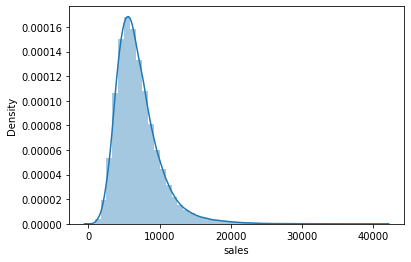

In [35]:
sns.distplot(df3['sales'],kde=True)

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

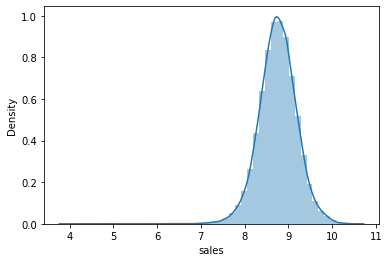

In [36]:
sns.distplot(np.log1p(df3['sales']))

## 3.2 Analise univariada


### 3.2.1 numerical variables


array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

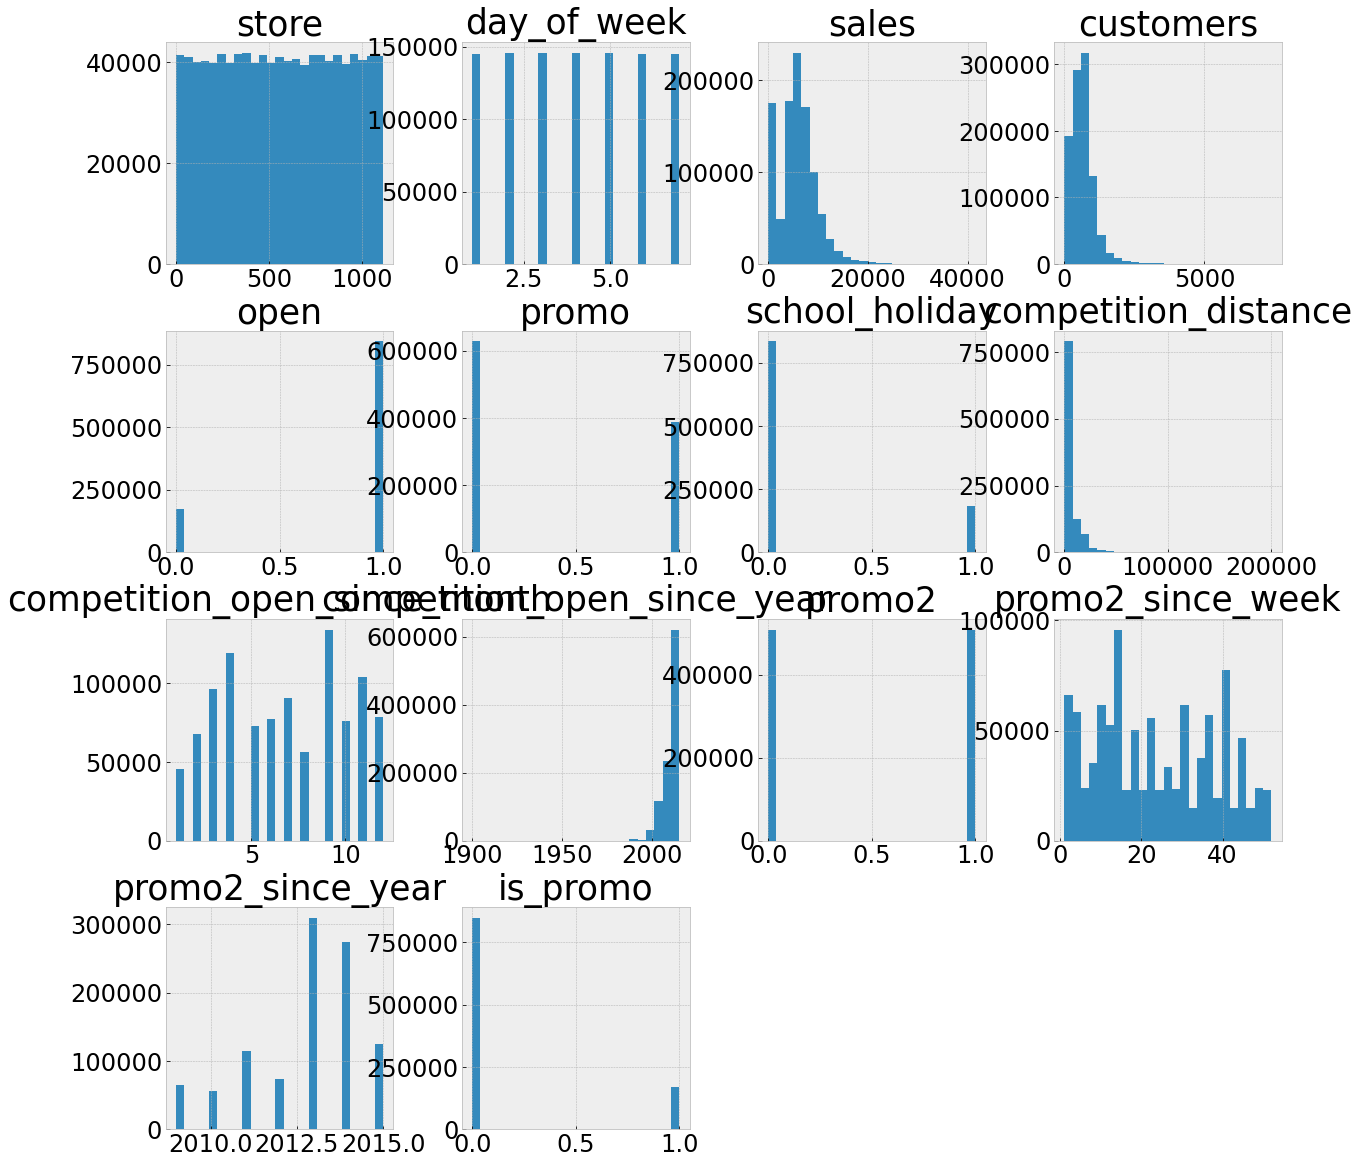

In [49]:
num_attributes.hist(bins=25,figsize=(20,20))

### 3.2.2 categorical variables
countplot + kdeplot
verificar dependencias ( se os feriados tem importancia nas vendas

## 3.3 Analise Bivariada
analisar cada variavel com o fenomeno e isso inclui:
Validar Hipoteses + correlacao de pearson



##3.4 Analise multivariada

pearson pra att e cat variables entre si

# 4. DATA MODELING

Normalização, Rescale(MinMax/Robust), Encoding and Transformation

# 5. SELECT ATTRIBUTES

BORUTA + EXPLORATORY DATA ANALYSIS

# 6. MACHINE LEARNING ALGORITHMS



## 6.1 CROSS-VALIDATION

## 6.2 FINE TUNING